# 机器学习进阶毕业项目

## 猫狗大战

——张红亮，优达学城

### 载入项目所需模块

In [1]:
import os, cv2, random, pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import csv
import shutil
import h5py

from urllib.request import urlretrieve
from os.path import isfile, isdir
import utils
from utils import *
import tarfile

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

from keras.layers import Input, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop,Nadam,SGD,Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.utils import np_utils
from keras.models import load_model

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, ELU

from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras import layers

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 数据获取

In [3]:
# 下载Oxford-IIIT Pet Dataset补充数据集

image_supply_path = './input/images'

image_supply_loacation = './images.tar.gz'

if isfile(image_supply_loacation):
    tar_gz_path = image_supply_loacation
else:
    tar_gz_path = 'images.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path ):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='images supply dataset') as pbar:
        urlretrieve('http://www.robots.ox.ac.uk/%7Evgg/data/pets/data/images.tar.gz', tar_gz_path, pbar.hook)

if not isdir(image_supply_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall(path='./input/')
        tar.close()

test_folder_path(image_supply_path)

All files found!


### 数据可视化

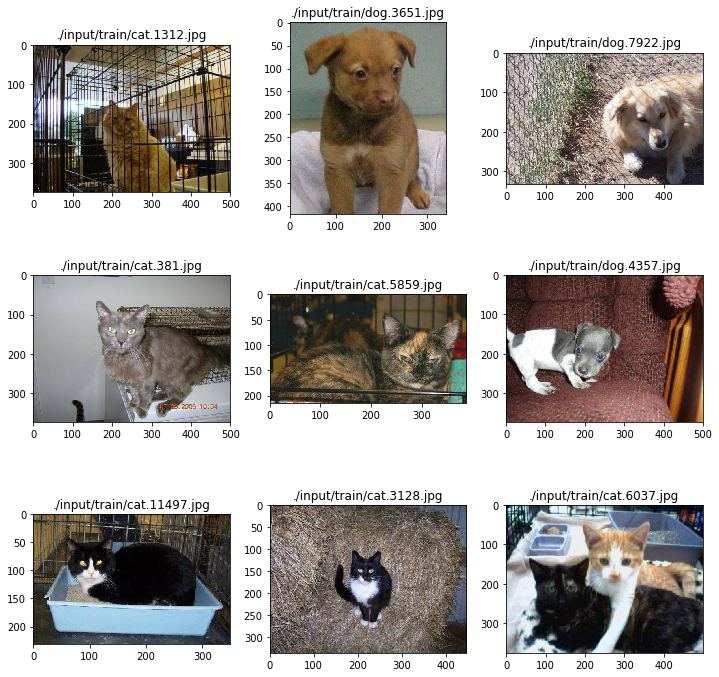

In [129]:
TRAIN_DIR = './input/train/'
train_images_path = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

# 随机展示9张图片

random.seed(2018)

def random_show(location):
    plt.subplot(location)
    sample = random.choice(train_images_path)
    img = cv2.imread(sample)
    b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
    rgb_img = cv2.merge([r,g,b])
    plt.title(sample)
    plt.imshow(rgb_img)
    
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for location in range(331, 340):
    random_show(location)
plt.show()

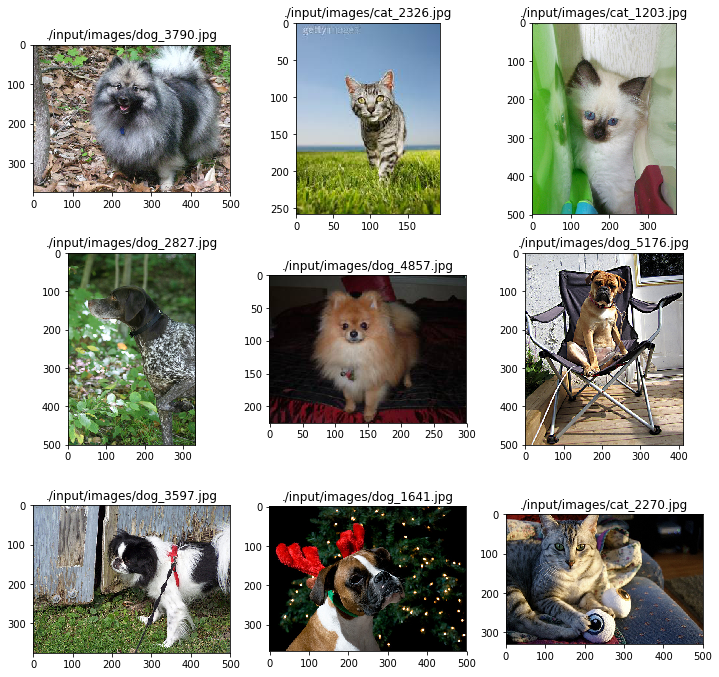

In [9]:
# 随机展示9张补充集图片

random.seed(2018)

TRAIN_SUP_DIR = './input/images/'
train_images_path_sup = [TRAIN_SUP_DIR + file for file in os.listdir(TRAIN_SUP_DIR)]

def random_show(location):
    plt.subplot(location)
    sample = random.choice(train_images_path_sup)
    img = cv2.imread(sample)
    b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
    rgb_img = cv2.merge([r,g,b])
    plt.title(sample)
    plt.imshow(rgb_img)
    
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for location in range(331, 340):
    random_show(location)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:21<00:00, 305.30it/s]


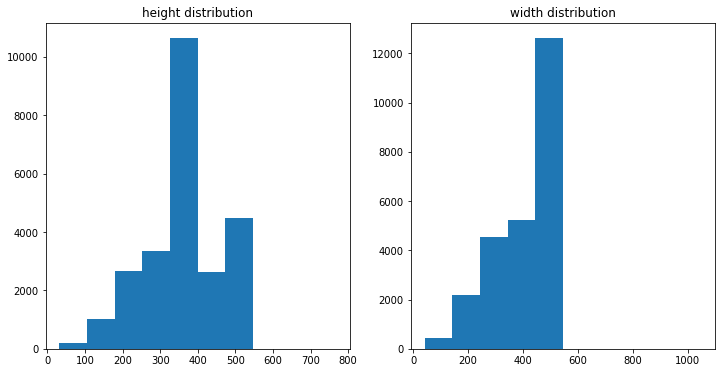

median of height: 374.0
median of width: 447.0


In [10]:
# 以直方图展示图片的宽高分布——kaggle训练集

height = []
width = []

for file in tqdm(train_images_path):
    image = cv2.imread(file)
    height.append(image.shape[0])
    width.append(image.shape[1])
    
plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
plt.subplot(121)
plt.hist(height)
plt.title("height distribution")

plt.subplot(122)
plt.hist(width)
plt.title("width distribution")

plt.show()

print('median of height: {}'.format(np.median(height)))
print('median of width: {}'.format(np.median(width)))

100%|██████████████████████████████████████████████████████████████████████████████| 7393/7393 [03:48<00:00, 32.42it/s]


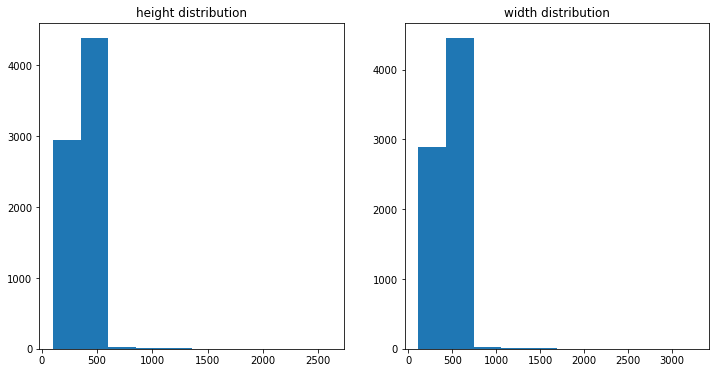

median of height: 375.0
median of width: 500.0


In [13]:
# 以直方图展示图片的宽高分布——补充数据集

height = []
width = []

for file in tqdm(train_images_path_sup):
    image = cv2.imread(file)
    if np.any(image != None):# 当图片可以读取时，处理读取图片失败的情况
        height.append(image.shape[0])
        width.append(image.shape[1])
    
plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
plt.subplot(121)
plt.hist(height)
plt.title("height distribution")

plt.subplot(122)
plt.hist(width)
plt.title("width distribution")

plt.show()

print('median of height: {}'.format(np.median(height)))
print('median of width: {}'.format(np.median(width)))

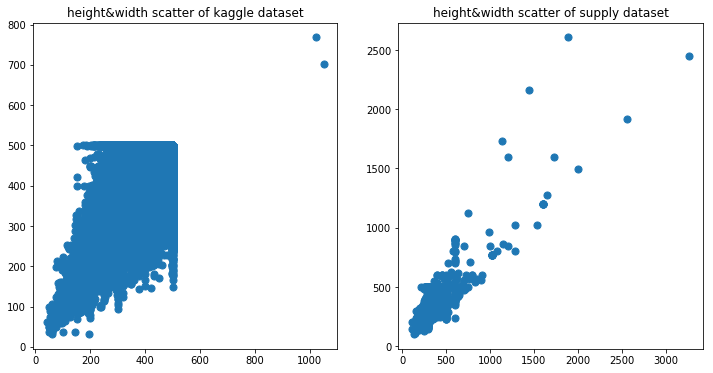

median of kaggle height: 374.0, median of kaggle width: 447.0
median of supply height: 375.0, median of supply width: 500.0


In [14]:
# 以散点图展示图片的宽高分布

height_kg = []
width_kg = []
height_su = []
width_su = []

for file in train_images_path:
    image = cv2.imread(file)
    height_kg.append(image.shape[0])
    width_kg.append(image.shape[1])
    
for file in train_images_path_sup:
    image = cv2.imread(file)
    if np.any(image != None):# 当图片可以读取时，处理读取图片失败的情况
        height_su.append(image.shape[0])
        width_su.append(image.shape[1])

plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
plt.subplot(121)
plt.scatter(width_kg, height_kg, s=50)
plt.title("height&width scatter of kaggle dataset")

plt.subplot(122)
plt.scatter(width_su, height_su, s=50)
plt.title("height&width scatter of supply dataset")

plt.show()

print('median of kaggle height: {}, median of kaggle width: {}'.format(np.median(height_kg),np.median(width_kg)))
print('median of supply height: {}, median of supply width: {}'.format(np.median(height_su),np.median(width_su)))

### 单模型——ResNet50

### 数据预处理

In [3]:
# 利用预训练模型对训练集数据进行异常检测

model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


In [7]:
# 把图片读取出来放到列表中

file_list = train_images_path + train_images_path_sup
img = []
for i in tqdm(range(len(file_list))):
    images = image.load_img(file_list[i], target_size=(224, 224))
    x = image.img_to_array(images)
    x = np.expand_dims(x, axis=0)
    img.append(x)

100%|██████████| 32390/32390 [03:26<00:00, 156.87it/s]


In [13]:
# 把图片list联合在一起
images = np.concatenate([x for x in img])

In [15]:
# 使用预训练模型预测
preds = model.predict(images, batch_size=128, verbose=1)

# 获取训练集数据预训练模型top-50分类数据
predict_array = decode_predictions(preds, top=50)

32390/32390 [==============================] - 328s 10ms/step


In [24]:
# 读取imagenet猫狗类型
cats_dogs_category_list = []

csv_file = csv.reader(open('imagenet_cats_dogs.csv'))
for category in csv_file:
    cats_dogs_category_list.append(category)
    
cats_dogs_category_array = np.array(cats_dogs_category_list)

In [89]:
# 测试imagenet猫狗类型是否在预训练模型预测Top-50中
test_result_list = []
def test_image(predict_array, check_array):
    for key, value in tqdm(enumerate(predict_array)):
        i = 0
        for result in value:
            if result[0] in check_array:
                break # top-50在猫狗类型中，退出当前循环
            else:
                i = i + 1
        if i == 50:
            test_result_list.append(file_list[key]) # 如果top-50都不在猫狗类型中，添加到array里

    return test_result_list
                
test_result_list = test_image(predict_array, cats_dogs_category_array)
print('len of test_result_list :{}'.format(len(test_result_list)))

32390it [00:00, 91957.44it/s]

len of test_result_list :107


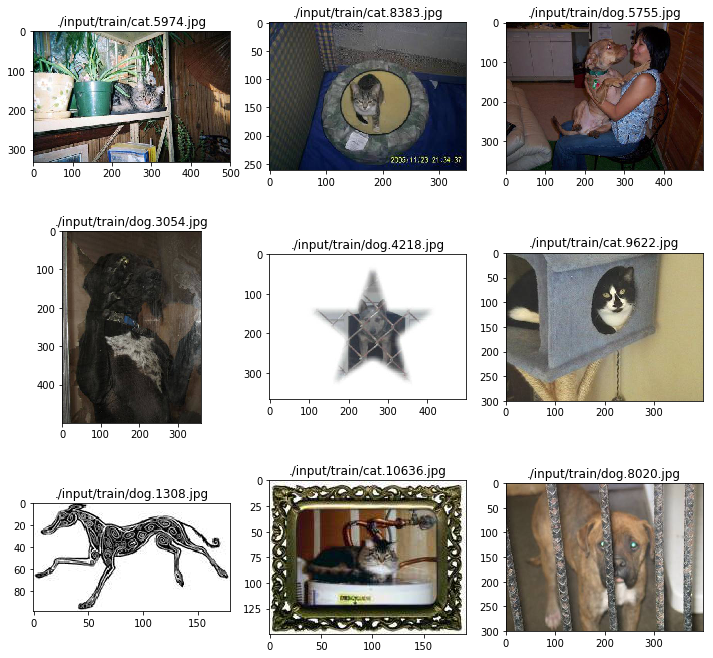

In [115]:
# 随机展示9张异常图片
random.seed(2018)
def random_show(location):
    plt.subplot(location)
    sample = random.choice(test_result_list)
    img = cv2.imread(sample)
    b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
    rgb_img = cv2.merge([r,g,b])
    plt.title(sample)
    plt.imshow(rgb_img)
    
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for location in range(331, 340):
    random_show(location)
plt.show()

#### kaggle训练集预处理

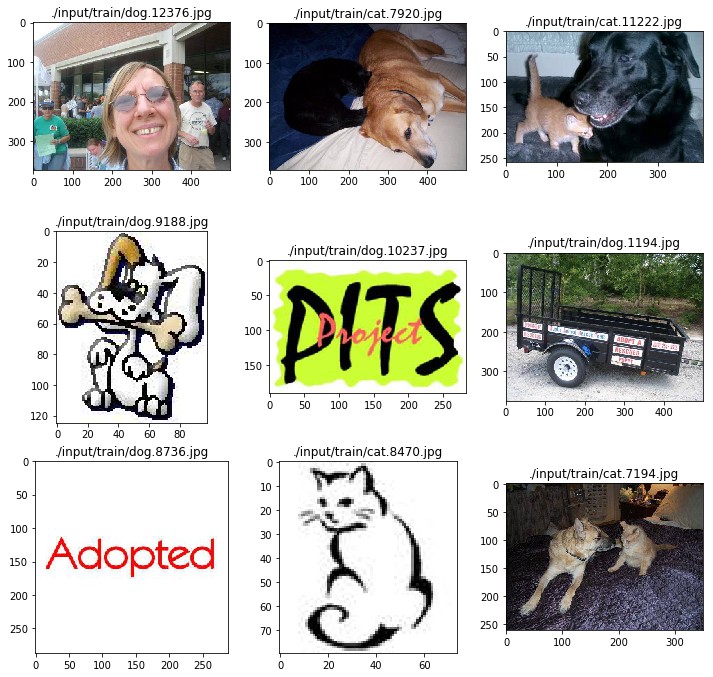

In [130]:
# 获取异常图片列表

random.seed(2018)

ab_img_list = []

csv_file = csv.reader(open('relabel.csv'))
for filename in csv_file:
    if 'dog' in filename[1] or 'cat' in filename[1]:
        if '.jpg' not in filename[1]:
            filename = filename[1] + '.jpg'
            ab_img_list.append(filename)
        else:
            ab_img_list.append(filename[1])    
    else:
        pass

for i, file in enumerate(ab_img_list):
    ab_img_list[i] = './input/train/' + file
    
# 随机展示9张异常图片
def random_show(location):
    plt.subplot(location)
    sample = random.choice(ab_img_list)
    img = cv2.imread(sample)
    b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
    rgb_img = cv2.merge([r,g,b])
    plt.title(sample)
    plt.imshow(rgb_img)
    
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for location in range(331, 340):
    random_show(location)
plt.show()

In [131]:
# 删除训练集中异常的图片

ab_img_list = []

csv_file = csv.reader(open('relabel.csv'))
for filename in csv_file:
    if 'dog' in filename[1] or 'cat' in filename[1]:
        if '.jpg' not in filename[1]:
            filename = filename[1] + '.jpg'
            ab_img_list.append(filename)
        else:
            ab_img_list.append(filename[1])    
    else:
        pass

for i, file in enumerate(ab_img_list):
    ab_img_list[i] = './input/train/' + file

i = 0
for file in train_images_path:
    if file in ab_img_list:
        train_images_path.remove(file)
        i = i + 1
print('deleted {} files.'.format(i))

deleted 49 files.


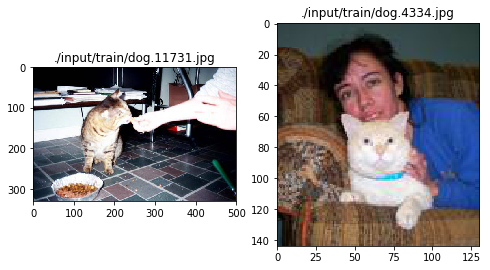

In [132]:
# 展示两张打错标签的图片

wrong_label_list = ['./input/train/dog.11731.jpg', './input/train/dog.4334.jpg']


plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(121)
img = cv2.imread(wrong_label_list[0])
b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
rgb_img = cv2.merge([r,g,b])
plt.title(wrong_label_list[0])
plt.imshow(rgb_img)
    
plt.subplot(122)
img = cv2.imread(wrong_label_list[1])
b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
rgb_img = cv2.merge([r,g,b])
plt.title(wrong_label_list[1])
plt.imshow(rgb_img)

plt.show()

In [133]:
# 删除打错标签的两张图片

wrong_label_list = ['./input/train/dog.11731.jpg', './input/train/dog.4334.jpg']

i = 0
for file in train_images_path:
    if file in wrong_label_list:
        train_images_path.remove(file)
        i = i + 1
print('deleted {} files.'.format(i))

deleted 2 files.


#### 补充训练集预处理

In [11]:
# 修改补充数据集文件名，以dog.x和cat.x命名

# utils写好了修改文件名方法：trange_file_name
trange_file_name('./input/images/')

7393it [00:00, 78278.37it/s]


In [101]:
# 找到补充训练集无法正常读取的图片

TRAIN_DIR_SUP = './input/images/'
train_images_path_sup = [TRAIN_DIR_SUP+i for i in os.listdir(TRAIN_DIR_SUP)] 


none_img_list=[]

for file in tqdm(train_images_path_sup):
    image = cv2.imread(file)
    if np.any(image == None):
        none_img_list.append(file)
        print(file)

# 删除补充集无法读取的图片
i = 0
for file in train_images_path_sup:
    if file in none_img_list:
        train_images_path_sup.remove(file)
        i = i + 1
        
print('deleted {} files.'.format(i))

 44%|████▍     | 3286/7390 [01:10<01:27, 46.67it/s]

./input/images/cat_5597.jpg


 63%|██████▎   | 4653/7390 [01:39<00:58, 46.82it/s]

./input/images/cat_1399.jpg


 72%|███████▏  | 5291/7390 [01:52<00:44, 47.02it/s]

./input/images/cat_4197.jpg


 77%|███████▋  | 5697/7390 [02:01<00:36, 46.90it/s]

./input/images/cat_5760.jpg


 93%|█████████▎| 6888/7390 [02:26<00:10, 46.86it/s]

./input/images/cat_7252.jpg


 98%|█████████▊| 7242/7390 [02:34<00:03, 46.96it/s]

./input/images/cat_2717.jpg


100%|██████████| 7390/7390 [02:37<00:00, 47.02it/s]

deleted 6 files.


In [134]:
# kaggle训练集与补充训练集融合
train_images = train_images_path + train_images_path_sup

# 删除预训练模型异常检测结果列表中的图片
i = 0
for file in train_images:
    if file in test_result_list:
        train_images.remove(file)
        i = i + 1
        
print('deleted {} files.'.format(i))

deleted 91 files.


In [137]:
len(train_images)

32242

#### kaggle训练集与补充数据集融合

In [141]:
# 对训练集数据做乱序处理

random.seed(2018)
random.shuffle(train_images)


ROWS=350
COLS=350
CHANNELS=3

def read_image(file_path):
    '''
    读取图片
    '''
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
    rgb_img = cv2.merge([r,g,b])
    return cv2.resize(rgb_img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC) # 对训练图片做缩放处理

def prep_train_data(images_path):
    '''
    训练集数据预处理
    '''
    
    # 对labels进行独热编码
    labels = np.zeros((len(images_path), 2), dtype=np.uint8)
    
    for i, path in enumerate(images_path):
        if 'dog' in path:
            labels[i][0] = 1
        else:
            labels[i][1] = 1
    
    count = len(images_path)
    features = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in tqdm(enumerate(images_path)):
        image = read_image(image_file)
        image.transpose((1,0,2))
        features[i] = image
#         if i%2500 == 0: print('Processed {} of {}'.format(i, count))

    return features, labels

features, labels = prep_train_data(train_images)

print("features shape: {}".format(features.shape))
print("labels shape: {}".format(labels.shape))

In [119]:
# 图片均值归一化

# 获取全部训练集图片3个通道所有像素点的平均值
mean_value = features.mean(axis=0)

for key, value in tqdm(enumerate(features)):
    features[key] = value - mean_value   

In [ ]:
# 训练集数据保存
pickle.dump((features, labels), open('train_data.p', 'wb'))
print('save data done!')

In [ ]:
# 训练集数据读取
features, labels = pickle.load(open('train_data_batch.p', mode='rb'))
print('load data done!')

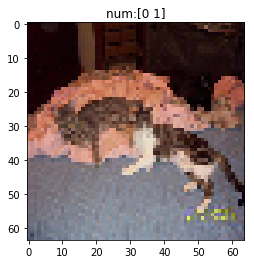

In [22]:
# 读取数据后验证，随机展示一张图片
random.seed(2018)
image_index = random.choice(range(len(features)))
image_file = features[image_index]
plt.imshow(image_file)
plt.title('num:{}'.format(labels[image_index]))
plt.show()

### 构建CNN模型

In [19]:
# ResNet50 with ELU


# optimizer = RMSprop(lr=1e-4)
# optimizer=SGD(0.001, momentum=0.9, nesterov=True)
# optimizer = SGD
optimizer = Nadam(lr=0.0005)
objective = 'binary_crossentropy'

base_model = ResNet50(include_top=False, weights='imagenet')

for layer in base_model.layers:
            layer.trainable = False

head = base_model.output
batchnormed_1 = BatchNormalization(axis=3)(head)
avgpooled = GlobalAveragePooling2D()(batchnormed_1)
dense = Dense(256)(avgpooled)
batchnormed_2 = BatchNormalization()(dense)
relu = ELU()(batchnormed_2)
dropout = Dropout(0.2)(relu)

# dense = Dense(256)(dropout)
# batchnormed_2 = BatchNormalization()(dense)
# relu = ELU()(batchnormed_2)
# dropout = Dropout(0.2)(relu)

output = Dense(2, activation='sigmoid')(dropout)
model = Model(base_model.input, output)

model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])

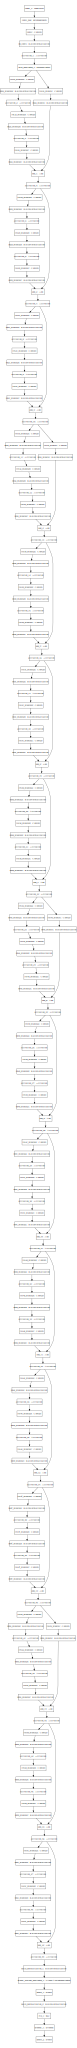

In [21]:
# 利用model_to_dot查看模型结构
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [1]:
# 查看模型参数
# model.summary()

### 模型训练

In [23]:
# 模型训练

random.seed(2018)

nb_epoch = 20
batch_size = 128

# 保存训练过程中验证集上表现最好的模型
val_checkpoint = ModelCheckpoint('resnet_bestval_{val_loss:.4f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# cur_checkpoint = ModelCheckpoint('current.h5')

# 当模型在2个epoch上未提高时，降低2倍学习率
lrSchduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)

# 自定义callback回调函数，在epoch结束时写入loss和val_loss
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# 为了减少模型训练时间，同时防止过拟合，使用early_stopping在模型不提高性能的5个epoch后停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')


# 由于训练数据是按照猫和狗依次排序的，因此在训练过程中对训练集做乱序处理，shuffle=True
def run_catdog():
    
    history = LossHistory()
    model.fit(features, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.2, verbose=1, shuffle=True, 
              callbacks=[history, early_stopping, val_checkpoint,lrSchduler])
    
    return history

history = run_catdog()

Train on 25866 samples, validate on 6467 samples
Epoch 1/20
25866/25866 [==============================] - 696s 27ms/step - loss: 0.0550 - acc: 0.9804 - val_loss: 0.0494 - val_acc: 0.9821

Epoch 00001: val_loss improved from inf to 0.04945, saving model to resnet_bestval_0.0494.h5
Epoch 2/20
25866/25866 [==============================] - 628s 24ms/step - loss: 0.0252 - acc: 0.9912 - val_loss: 0.0371 - val_acc: 0.9860

Epoch 00002: val_loss improved from 0.04945 to 0.03712, saving model to resnet_bestval_0.0371.h5
Epoch 3/20
25866/25866 [==============================] - 628s 24ms/step - loss: 0.0176 - acc: 0.9939 - val_loss: 0.0398 - val_acc: 0.9869

Epoch 00003: val_loss did not improve from 0.03712
Epoch 4/20
25866/25866 [==============================] - 628s 24ms/step - loss: 0.0179 - acc: 0.9933 - val_loss: 0.0374 - val_acc: 0.9871

Epoch 00004: val_loss did not improve from 0.03712

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/20
25866/2

In [6]:
# 模型训练过程可视化

loss = history.losses
val_loss = history.val_losses

from matplotlib import pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()

plt.show()

### 模型预测

In [38]:
# 读取在验证集上表现最优的模型，对测试集做预测
model = load_model('bestval_0.0329.h5')

In [3]:
# 测试集数据预处理

ROWS = 350
COLS = 350
CHANNELS = 3

TEST_DIR = './input/test/'

filenames = os.listdir(TEST_DIR)
filenames.sort(key=lambda x:int(x[:-4])) # 按文件名大小顺序排列

test_images_path =  [TEST_DIR+i for i in filenames]

test_images_path[:10]

['./test/test1/1.jpg',
 './test/test1/2.jpg',
 './test/test1/3.jpg',
 './test/test1/4.jpg',
 './test/test1/5.jpg',
 './test/test1/6.jpg',
 './test/test1/7.jpg',
 './test/test1/8.jpg',
 './test/test1/9.jpg',
 './test/test1/10.jpg']

In [4]:
ROWS=350
COLS=350
CHANNELS=3

def read_image(file_path):
    '''
    读取图片
    '''
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
    rgb_img = cv2.merge([r,g,b])
    return cv2.resize(rgb_img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC) # 对训练图片做缩放处理

def prep_test_data(images_path):
    '''
    测试集数据预处理
    '''
    count = len(images_path)
    test_images = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in tqdm(enumerate(images_path)):
        image = read_image(image_file)
        image.transpose(1,0,2)
        test_images[i] = image

    return test_images

test_images = prep_test_data(test_images_path)

12500it [02:07, 98.30it/s] 


In [ ]:
# 保存测试集数据

pickle.dump(test_images, open('test_data_350.p', 'wb'))
print('save data done!')

In [14]:
# 读取测试集数据

test_images = pickle.load(open('test_data_350.p', mode='rb'))
print('load data done!')

EOFError: Ran out of input

3532it [00:40, 88.30it/s] 

In [85]:
# 利用训练好的模型对测试集数据做预测

predictions = model.predict(test_images,batch_size=128, verbose=1)

12500/12500 [==============================] - 256s 20ms/step


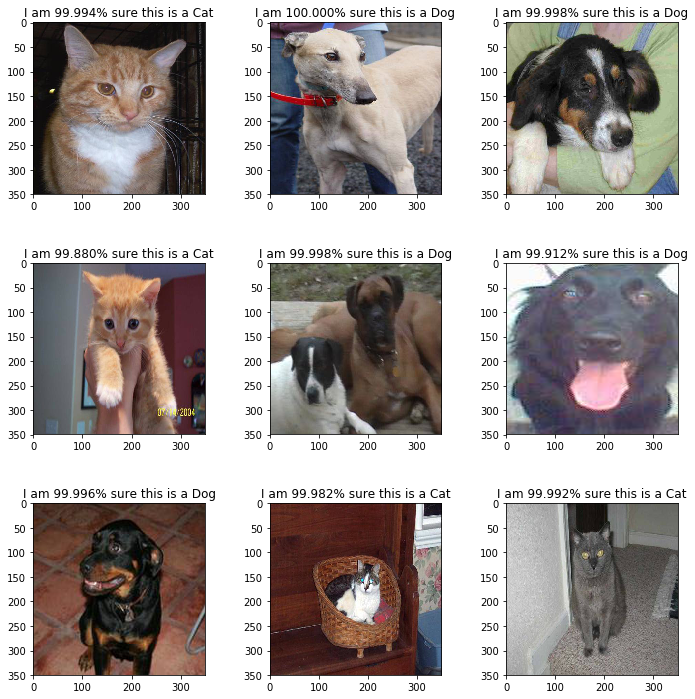

In [7]:
# 随机展示9条预测结果

random.seed(2018)

plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for location in range(331, 340):
    plt.subplot(location)
    for i in np.random.randint(low=0,high=12500,size=1):
        if predictions[i, 0] >= 0.5: 
            title = 'I am {:.3%} sure this is a Dog'.format(predictions[i][0])
        else: 
            title = 'I am {:.3%} sure this is a Cat'.format(predictions[i][1])
    plt.title(title)
    plt.imshow(test_images[i])
    
plt.show()

In [87]:
#由于kaggle采用log_loss作为评分标准，参考log_loss对无穷大问题的处理，使用clip对预测值空间做限制，能显著提高kaggle分数

predictions = predictions.clip(min=0.005, max=0.995)

In [88]:
# 把预测结果以kaggle规定格式和文件顺序写入csv文件

with open('submission_0.0328.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_0.0328.csv','a') as f:
    num = len(predictions)
    pred = 0
    
    for i in tqdm(range(0,num)):
        pred = predictions[i, 0]
        
        f.write('{},{}\n'.format(i+1, pred))
        
f.close()
print('file closed!')

100%|██████████| 12500/12500 [00:00<00:00, 376849.43it/s]

file closed!


### 使用多模型融合

### 数据预处理

In [104]:
# 创建目录

import os
import shutil


TTRAIN_DIR = './input/train/'
train_images = os.listdir(TTRAIN_DIR)
train_cats = [file for file in train_images if 'cat' in file]
train_dogs = [file for file in train_images if 'dog' in file]

TEST_DIR = './input/test/'
test_images = [file for file in os.listdir(TEST_DIR)]

def mkdir(path):
 
    isExists=os.path.exists(path)
 
    if not isExists:
        os.makedirs(path) 
 
        print(':{} 创建成功'.format(path))
        return True
    else:
        print(':{} 目录已存在'.format(path))
        return False
 
# 定义要创建的目录
mkpath_list=['./mydata2/', './mydata2/train/', './mydata2/train/cats/', 
             './mydata2/train/dogs/', './mydata2/validation/', './mydata2/test1/', './mydata2/test1/test/']

for path in mkpath_list:
    mkdir(path)

:./mydata2/ 创建成功
:./mydata2/train/ 创建成功
:./mydata2/train/cats/ 创建成功
:./mydata2/train/dogs/ 创建成功
:./mydata2/validation/ 创建成功
:./mydata2/test1/ 创建成功
:./mydata2/test1/test/ 创建成功


In [105]:
def copyfile(path, str, new_path):
    '''
    指定文件复制
    '''
    i = 0
    for file in path:
        if str in file:
            shutil.copy(file, new_path)
            i = i+1
    print('copyed {} {} images to {}'.format(i, str, new_path))

In [106]:
def copyfileno(path, new_path):
    '''
    不指定文件复制
    '''
    i = 0
    for file in path:
        shutil.copy(file, new_path)
        i = i+1
    print('copyed {} images to {}'.format(i, new_path))

In [107]:
TRAIN_DIR = './input/train/'
train_images = [TRAIN_DIR + file for file in os.listdir(TTRAIN_DIR)]

TEST_DIR = './input/test/'
test_images = [TEST_DIR + file for file in os.listdir(TEST_DIR)]

TRAIN_SUP_DIR = './input/images/'
train_sup_images = [TRAIN_SUP_DIR + file for file in os.listdir(TRAIN_SUP_DIR)]

# 把kaggle训练集、补充数据集和kaggle测试集的数据复制一份到相应的文件夹下
copyfile(train_images, 'dog', './mydata2/train/dogs/')
copyfile(train_images, 'cat', './mydata2/train/cats/')
copyfile(train_sup_images, 'dog', './mydata2/train/dogs/')
copyfile(train_sup_images, 'cat', './mydata2/train/cats/')
copyfileno(test_images, './mydata2/test1/test/')

copyed 12500 dog images to ./mydata2/train/dogs/
copyed 12500 cat images to ./mydata2/train/cats/
copyed 4990 dog images to ./mydata2/train/dogs/
copyed 2400 cat images to ./mydata2/train/cats/
copyed 12500 images to ./mydata2/test1/test/


In [109]:
# 从文件夹中删除异常图片文件--49张

file_list = []
for path in ab_img_list:
    index = path.rfind('/')
    file = path[index+1:]
    file_list.append(file)

i = 0
for file in os.listdir('./mydata2/train/dogs/'):
    if file in file_list:
        os.remove('./mydata2/train/dogs/' + file)
        i = i + 1

for file in os.listdir('./mydata2/train/cats/'):
    if file in file_list:
        os.remove('./mydata2/train/cats/' + file)
        i = i + 1

print('deleted {} files.'.format(i))

deleted 49 files.


In [110]:
# 从文件夹中删除错误标记的图片--2张

file_list = []
for path in wrong_label_list:
    index = path.rfind('/')
    file = path[index+1:]
    file_list.append(file)

i = 0
for file in os.listdir('./mydata2/train/dogs/'):
    if file in file_list:
        os.remove('./mydata2/train/dogs/' + file)
        i = i + 1

for file in os.listdir('./mydata2/train/cats/'):
    if file in file_list:
        os.remove('./mydata2/train/cats/' + file)
        i = i + 1

print('deleted {} files.'.format(i))

deleted 2 files.


In [111]:
# 删除补充数据集中无法读取的异常图片
        
file_list = []
for path in none_img_list:
    index = path.rfind('/')
    file = path[index+1:]
    file_list.append(file)

i = 0
for file in os.listdir('./mydata2/train/dogs/'):
    if file in file_list:
        os.remove('./mydata2/train/dogs/' + file)
        i = i + 1

for file in os.listdir('./mydata2/train/cats/'):
    if file in file_list:
        os.remove('./mydata2/train/cats/' + file)
        i = i + 1
        
print('deleted {} files.'.format(i))

deleted 6 files.


In [114]:
# 删除预训练模型检测异常的图片

file_list = []
for path in test_result_list:
    index = path.rfind('/')
    file = path[index+1:]
    file_list.append(file)

i = 0
for file in os.listdir('./mydata2/train/dogs/'):
    if 'dog' in file and file in file_list:
        os.remove('./mydata2/train/dogs/' + file)
        i = i + 1

for file in os.listdir('./mydata2/train/cats/'):
    if 'cat' in file and file in file_list:
        os.remove('./mydata2/train/cats/' + file)
        i = i + 1
        
print('deleted {} files.'.format(i))

deleted 92 files.


In [31]:
def write_feature_vectors(MODEL, image_size, lambda_func=None):
    '''
    获取训练数据和测试数据的基于keras预训练模型的特征向量
    '''
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("./mydata2/train", image_size, shuffle=False, batch_size=16)
    test_generator = gen.flow_from_directory("./mydata2/test1", image_size, shuffle=False, batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, verbose=1)
    test = model.predict_generator(test_generator, verbose=1)
    with h5py.File('fv_{}_{}.h5'.format(MODEL.__name__, width)) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [32]:
# 使用模型默认图片大小

# write_feature_vectors(VGG16, (224, 224))
write_feature_vectors(ResNet50, (224, 224), resnet50.preprocess_input)
write_feature_vectors(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_feature_vectors(Xception, (299, 299), xception.preprocess_input)

In [33]:
# 使用350*350图片大小

# write_feature_vectors(VGG16, (350, 350))
write_feature_vectors(ResNet50, (350, 350), resnet50.preprocess_input)
write_feature_vectors(InceptionV3, (350, 350), inception_v3.preprocess_input)
write_feature_vectors(Xception, (350, 350), xception.preprocess_input)

### 构建CNN模型

In [2]:
# 模型融合

random.seed(2018)

X_train = []
X_test = []

for filename in ["fv_ResNet50.h5", "fv_Xception.h5", "fv_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

In [46]:
# 模型构建，直接在预训练模型后加分类器

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

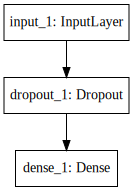

In [37]:
# 利用model_to_dot查看模型结构
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [38]:
# 查看模型参数
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6144)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6145      
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


### 模型训练

In [45]:
# 模型训练


nb_epoch = 20
batch_size = 128

# 保存训练过程中验证集上表现最好的模型
val_checkpoint = ModelCheckpoint('resnet_bestval_{val_loss:.4f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# cur_checkpoint = ModelCheckpoint('current.h5')

# 当模型在2个epoch上未提高时，降低2倍学习率
lrSchduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)

# 自定义callback回调函数，在epoch结束时写入loss和val_loss
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# 为了减少模型训练时间，同时防止过拟合，使用early_stopping在模型不提高性能的5个epoch后停止训练
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')


# 在训练过程中对训练集做乱序处理，shuffle=True
def run_catdog():
    
    history = LossHistory()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.2, verbose=1, shuffle=True, 
              callbacks=[history, early_stopping, val_checkpoint,lrSchduler])
    
    return history

history = run_catdog()

Train on 25867 samples, validate on 6467 samples
Epoch 1/20
25867/25867 [==============================] - 2s 77us/step - loss: 0.0640 - acc: 0.9781 - val_loss: 0.0407 - val_acc: 0.9934

Epoch 00001: val_loss improved from inf to 0.04074, saving model to resnet_bestval_0.0407.h5
Epoch 2/20
25867/25867 [==============================] - 1s 44us/step - loss: 0.0168 - acc: 0.9951 - val_loss: 0.0161 - val_acc: 0.9969

Epoch 00002: val_loss improved from 0.04074 to 0.01613, saving model to resnet_bestval_0.0161.h5
Epoch 3/20
25867/25867 [==============================] - 1s 43us/step - loss: 0.0145 - acc: 0.9956 - val_loss: 0.0135 - val_acc: 0.9964

Epoch 00003: val_loss improved from 0.01613 to 0.01349, saving model to resnet_bestval_0.0135.h5
Epoch 4/20
25867/25867 [==============================] - 1s 44us/step - loss: 0.0121 - acc: 0.9959 - val_loss: 0.0158 - val_acc: 0.9960

Epoch 00004: val_loss did not improve from 0.01349
Epoch 5/20
25867/25867 [==============================] - 1s 

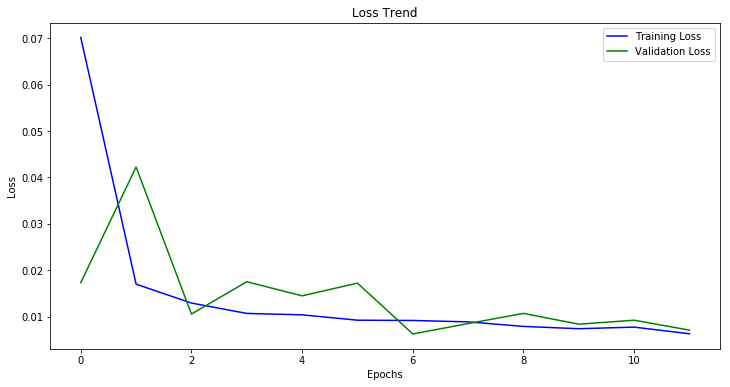

In [76]:
# 模型训练过程可视化

loss = history.losses
val_loss = history.val_losses


plt.figure(figsize=(12,6))

plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()

plt.show()

### 模型预测

In [3]:
# 加载在验证集上表现最优的模型
model = load_model('mix_bestval_0.0069.h5')

In [4]:
# 利用训练好的模型对测试集做预测

predictions = model.predict(X_test, verbose=1)

12500/12500 [==============================] - 1s 50us/step


In [8]:
predictions = pickle.load(open('predictions.p', mode='rb'))

In [5]:
predictions[:10]

array([[9.9984729e-01],
       [6.4735364e-06],
       [1.6646410e-04],
       [9.9998653e-01],
       [9.9998856e-01],
       [4.4113831e-06],
       [6.1307808e-05],
       [9.9979514e-01],
       [9.9811792e-01],
       [4.7327758e-06]], dtype=float32)

In [12]:
# 获取X_test列表
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("./test", (224, 224), shuffle=False, batch_size=16, class_mode=None)

file_list = []

for i, file in enumerate(test_generator.filenames):
    index_1 = file.rfind('\\')
    index_2 = file.rfind('.')
    file_name = int(file[index_1+1:index_2])
    file_list.append(file_name)

file_list = np.array(file_list)

Found 12500 images belonging to 1 classes.


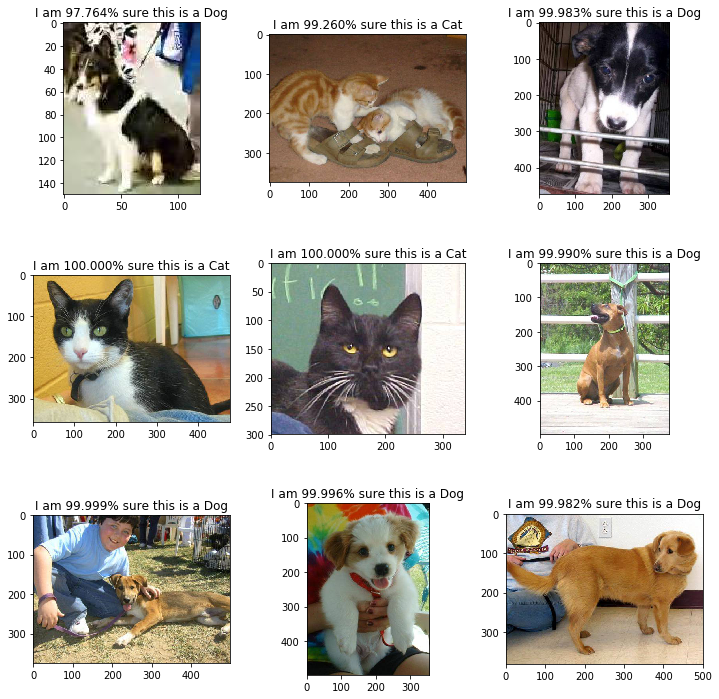

In [20]:
# 随机展示9条预测结果

random.seed(2018)
test_images_path = './mydata2/test1/'

plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for location in range(331, 340):
    plt.subplot(location)
    for i in np.random.randint(low=0,high=12500,size=1):
        if predictions[i] >= 0.5: 
#             print(predictions[i])
            title = 'I am {:.3%} sure this is a Dog'.format(float(predictions[i]))
        else: 
#             print(predictions[i])
            title = 'I am {:.3%} sure this is a Cat'.format(float(1-predictions[i]))
        plt.title(title)  
        file = test_generator.filenames[i]
        img = cv2.imread(test_images_path + file)
        b,g,r = cv2.split(img) # 改变图片通道：BGR → RGB
        rgb_img = cv2.merge([r,g,b])
        plt.imshow(rgb_img)
    
plt.show()

In [57]:
# 获取file_list正序排序，并根据此顺序对predictions排序
file_list_index = np.argsort(file_list)

p = np.zeros((len(predictions)), dtype=np.float32)
for key,value in enumerate(file_list_index):
    p[key] = predictions[value]
    
predictions = p

In [59]:
predictions[:10]

array([9.9984729e-01, 9.9999475e-01, 9.9998832e-01, 9.9989271e-01,
       7.1073515e-07, 2.3044984e-06, 2.0153166e-05, 8.1204325e-06,
       6.5342442e-07, 6.4735364e-06], dtype=float32)

In [60]:
#由于kaggle采用log_loss作为评分标准，参考log_loss对无穷大问题的处理，使用clip对预测值空间做限制，能显著提高kaggle分数

predictions = predictions.clip(min=0.005, max=0.995)

In [61]:
with open('submission_0.0069.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_0.0069.csv','a') as f:
    num = len(predictions)
    pred = 0
    
    for i in tqdm(range(0,num)):
        pred = predictions[i]
        
        f.write('{},{}\n'.format(i+1, pred))
        
f.close()
print('file closed!')

100%|██████████| 12500/12500 [00:00<00:00, 367076.48it/s]

file closed!
